### Prediksi Persetujuan Klaim Asuransi Kendaraan dengan XGBoost

Pada kegiatan ini kita akan menggunakan XGBoost untuk memprediksi persetujuan klaim asuransi kendaraan. Dataset yang digunakan adalah `Prediction Insurance.csv`

In [1]:
import xgboost
import pandas as pd

In [2]:
df = pd.read_csv("Prediction Insurance.csv")
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496,152,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26,1,1-2 Year,No,30170,26,88,0
381105,381106,Male,30,1,37,1,< 1 Year,No,40016,152,131,0
381106,381107,Male,21,1,30,1,< 1 Year,No,35118,160,161,0
381107,381108,Female,68,1,14,0,> 2 Years,Yes,44617,124,74,0


Mengecek kolom yang numerik dan kategorikal

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    381109 non-null  int64 
 1   Gender                381109 non-null  object
 2   Age                   381109 non-null  int64 
 3   Driving_License       381109 non-null  int64 
 4   Region_Code           381109 non-null  int64 
 5   Previously_Insured    381109 non-null  int64 
 6   Vehicle_Age           381109 non-null  object
 7   Vehicle_Damage        381109 non-null  object
 8   Annual_Premium        381109 non-null  int64 
 9   Policy_Sales_Channel  381109 non-null  int64 
 10  Vintage               381109 non-null  int64 
 11  Response              381109 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 34.9+ MB


Melihat distribusi data untuk data numerik

In [4]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


Cek daftar kelas data kategorikal

In [5]:
# check possible value for categorical columns
for column in df.select_dtypes(include=['object']).columns:
    print(f"Column: {column}")
    print(df[column].value_counts())
    print("\n")

Column: Gender
Gender
Male      206089
Female    175020
Name: count, dtype: int64


Column: Vehicle_Age
Vehicle_Age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64


Column: Vehicle_Damage
Vehicle_Damage
Yes    192413
No     188696
Name: count, dtype: int64




Simpan pemetaan data kategorikal ke integer, lalu ubah data berdasarkan pemetaan yang sudah dibuat.

In [6]:
### store column to id mapping to json, then map all categorical data to encoded data.
import json

# create a dictionary to store the mapping of each categorical column to its corresponding ID

if len(df.select_dtypes(include=['object']).columns) > 0:
    mapping = {}    
    for column in df.select_dtypes(include=['object']).columns:
        # get unique values for the column
        unique_values = df[column].unique()
        # create a dictionary to map each unique value to an ID
        value_to_id = {value: i for i, value in enumerate(unique_values)}
        # store the mapping in the main dictionary
        mapping[column] = value_to_id
    # save the mapping to a JSON file
    with open('mapping.json', 'w') as f:
        json.dump(mapping, f)
    # map all categorical data to encoded data
    for column in df.select_dtypes(include=['object']).columns:
        # get the mapping for this column from the main dictionary
        value_to_id = mapping[column]
        # replace each unique value with its corresponding ID
        df[column] = df[column].map(value_to_id)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28,0,0,0,40454,26,217,1
1,2,0,76,1,3,0,1,1,33536,26,183,0
2,3,0,47,1,28,0,0,0,38294,26,27,1
3,4,0,21,1,11,1,2,1,28619,152,203,0
4,5,1,29,1,41,1,2,1,27496,152,39,0


Melakukan normalisasi dengan StandardScaler agar setiap kolom memiliki rata-rata dan standar deviasi yang sama, lalu melakukan undersampling untuk mengurangi efek imbalance dataset.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
target_column = "Response"
# separate the target column from the rest of the data
y = df[target_column]
X = df.drop([target_column,"id"], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42,stratify=y)


### undersampling X_train and y_train to balance the classes
min_class_count = min(np.bincount(y_train))

X_train_resampled = []
y_train_resampled = []
for class_label in y_train.unique():
    # get the indices of samples belonging to this class
    indices = np.where(y_train == class_label)[0]
    # shuffle the indices to ensure randomness
    np.random.shuffle(indices)
    X_train_resampled.extend(X_train[indices][:min_class_count])
    y_train_resampled.extend([class_label] * min_class_count)
    

X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)
y_train_resampled = pd.Series(y_train_resampled)


Melatih model XGBoost

In [8]:
# train  model, then evaluate
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model:XGBClassifier = XGBClassifier(n_estimators =1000, eval_metric='logloss')
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7164335756080922


Menyimpan model sebagai pickle

In [9]:
# Dump model to pkl
import pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Melihat fitur-fitur yang berpengaruh

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

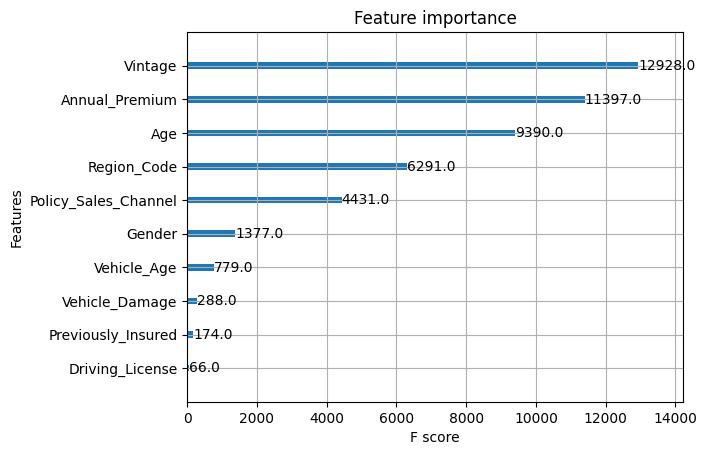

In [10]:
# most important features
from xgboost import plot_importance
plot_importance(model)


Melihat Confusion Matrix, yaitu matriks perbandingang antara kelas yang diprediksi dan kelas sebenarnya 

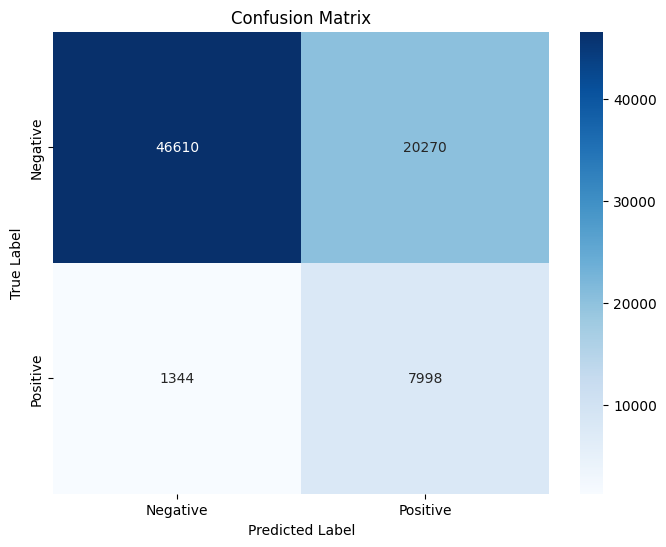

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
import seaborn as sns

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



Data Precision, Recall, dan F1-Score masing-masing kelas

In [15]:
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.70      0.81     66880
           1       0.28      0.86      0.43      9342

    accuracy                           0.72     76222
   macro avg       0.63      0.78      0.62     76222
weighted avg       0.89      0.72      0.76     76222



Precision-Recall Curve dari model yang dibuat.

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.70      0.81     66880
           1       0.28      0.86      0.43      9342

    accuracy                           0.72     76222
   macro avg       0.63      0.78      0.62     76222
weighted avg       0.89      0.72      0.76     76222



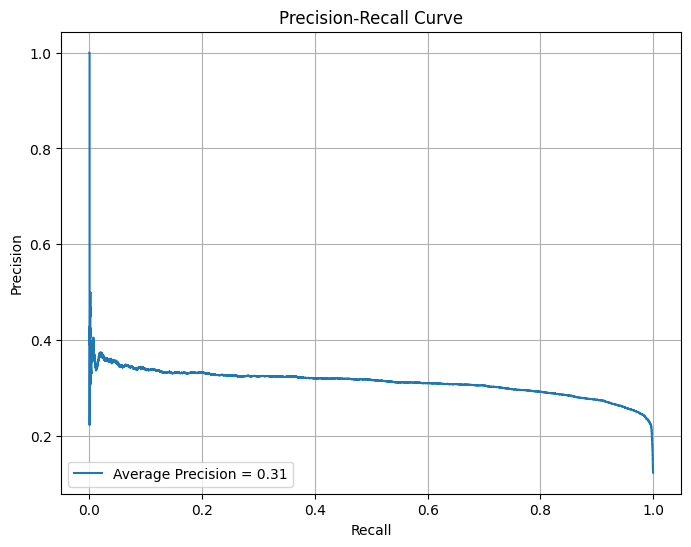

In [ ]:

precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Average Precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()




ROC Curve dari model yang dibuat.

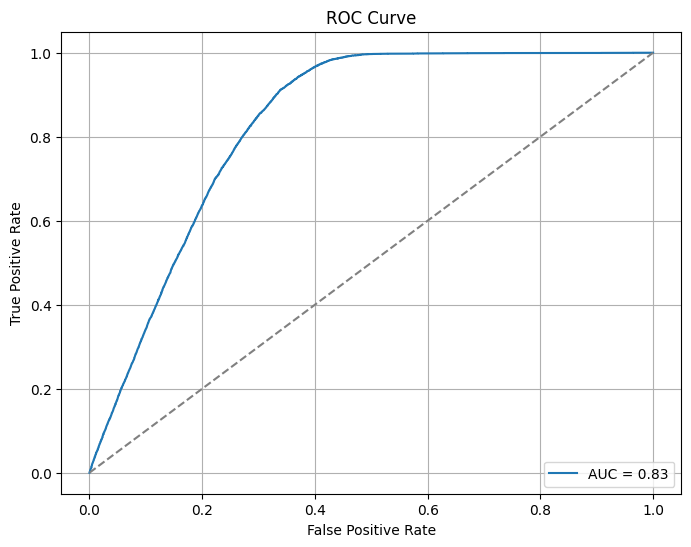

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()